In [1]:
from __future__ import unicode_literals

import sys
import os
from bs4 import BeautifulSoup
import urllib2
import cv2
from matplotlib import pyplot as plt
import matplotlib
from PIL import Image, ImageDraw, ImageFont

In [2]:
# from https://stackoverflow.com/questions/4460921/extract-the-first-paragraph-from-a-wikipedia-article-python
import re
import textwrap
import yaml
import urllib
import urllib2
import random

import wikipedia

In [3]:
# set utf-8
stdi, stdo, stde = sys.stdin, sys.stdout, sys.stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde
sys.getdefaultencoding()

'utf-8'


In [14]:
OUTPUT_PATH = '/home/will/sdb1/cvdata/wikipages500_3/'
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

In [5]:
DATA_SIZE = 500
IMG_SIZE = (227, 227)

In [6]:
LANG = {
    'en': 'https://en.wikipedia.org',
    'zh': 'https://zh.wikipedia.org',
    'ru': 'https://ru.wikipedia.org'
}

In [7]:
class WikipediaError(Exception):
    pass

In [8]:
class Wikipedia:
    url_article = 'http://%s.wikipedia.org/w/index.php?action=raw&title=%s'
    url_image = 'http://%s.wikipedia.org/w/index.php?title=Special:FilePath&file=%s'
    url_search = 'http://%s.wikipedia.org/w/api.php?action=query&list=search&srsearch=%s&sroffset=%d&srlimit=%d&format=yaml'
   
    def __init__(self, lang):
        self.lang = lang
   
    def __fetch(self, url):
        request = urllib2.Request(url)
        request.add_header('User-Agent', 'Mozilla/5.0')
       
        try:
            result = urllib2.urlopen(request)
        except urllib2.HTTPError, e:
            raise WikipediaError(e.code)
        except urllib2.URLError, e:
            raise WikipediaError(e.reason)
       
        return result
   
    def article(self, article):
        url = self.url_article % (self.lang, urllib.quote_plus(article))
        content = self.__fetch(url).read()
       
        if content.upper().startswith('#REDIRECT'):
            match = re.match('(?i)#REDIRECT \[\[([^\[\]]+)\]\]', content)
           
            if not match == None:
                return self.article(match.group(1))
           
            raise WikipediaError('Can\'t found redirect article.')
       
        return content
   
    def image(self, image, thumb=None):
        url = self.url_image % (self.lang, image)
        result = self.__fetch(url)
        content = result.read()
       
        if thumb:
            url = result.geturl() + '/' + thumb + 'px-' + image
            url = url.replace('/commons/', '/commons/thumb/')
            url = url.replace('/' + self.lang + '/', '/' + self.lang + '/thumb/')
           
            return self.__fetch(url).read()
       
        return content
   
    def search(self, query, page=1, limit=10):
        offset = (page - 1) * limit
        url = self.url_search % (self.lang, urllib.quote_plus(query), offset, limit)
        content = self.__fetch(url).read()
       
        parsed = yaml.load(content)
        search = parsed['query']['search']
       
        results = []
       
        if search:
            for article in search:
                title = article['title'].strip()
               
                snippet = article['snippet']
                snippet = re.sub(r'(?m)<.*?>', '', snippet)
                snippet = re.sub(r'\s+', ' ', snippet)
                snippet = snippet.replace(' . ', '. ')
                snippet = snippet.replace(' , ', ', ')
                snippet = snippet.strip()
               
                wordcount = article['wordcount']
               
                results.append({
                    'title' : title,
                    'snippet' : snippet,
                    'wordcount' : wordcount
                })
       
        # yaml.dump(results, default_style='', default_flow_style=False,
        #     allow_unicode=True)
        return results

In [9]:
def unwiki(wiki):
    """
   Remove wiki markup from the text.
   """
    wiki = re.sub(r'(?i)\{\{IPA(\-[^\|\{\}]+)*?\|([^\|\{\}]+)(\|[^\{\}]+)*?\}\}', lambda m: m.group(2), wiki)
    wiki = re.sub(r'(?i)\{\{Lang(\-[^\|\{\}]+)*?\|([^\|\{\}]+)(\|[^\{\}]+)*?\}\}', lambda m: m.group(2), wiki)
    wiki = re.sub(r'\{\{[^\{\}]+\}\}', '', wiki)
    wiki = re.sub(r'(?m)\{\{[^\{\}]+\}\}', '', wiki)
    wiki = re.sub(r'(?m)\{\|[^\{\}]*?\|\}', '', wiki)
    wiki = re.sub(r'(?i)\[\[Category:[^\[\]]*?\]\]', '', wiki)
    wiki = re.sub(r'(?i)\[\[Image:[^\[\]]*?\]\]', '', wiki)
    wiki = re.sub(r'(?i)\[\[File:[^\[\]]*?\]\]', '', wiki)
    wiki = re.sub(r'\[\[[^\[\]]*?\|([^\[\]]*?)\]\]', lambda m: m.group(1), wiki)
    wiki = re.sub(r'\[\[([^\[\]]+?)\]\]', lambda m: m.group(1), wiki)
    wiki = re.sub(r'\[\[([^\[\]]+?)\]\]', '', wiki)
    wiki = re.sub(r'(?i)File:[^\[\]]*?', '', wiki)
    wiki = re.sub(r'\[[^\[\]]*? ([^\[\]]*?)\]', lambda m: m.group(1), wiki)
    wiki = re.sub(r"''+", '', wiki)
    wiki = re.sub(r'(?m)^\*$', '', wiki)

    return wiki

def unhtml(html):
    """
   Remove HTML from the text.
   """
    html = re.sub(r'(?i)&nbsp;', ' ', html)
    html = re.sub(r'(?i)<br[ \\]*?>', '\n', html)
    html = re.sub(r'(?m)<!--.*?--\s*>', '', html)
    html = re.sub(r'(?i)<ref[^>]*>[^>]*<\/ ?ref>', '', html)
    html = re.sub(r'(?m)<.*?>', '', html)
    html = re.sub(r'(?i)&amp;', '&', html)

    return html

def punctuate(text):
    """
   Convert every text part into well-formed one-space
   separate paragraph.
   """
    text = re.sub(r'\r\n|\n|\r', '\n', text)
    text = re.sub(r'\n\n+', '\n\n', text)

    parts = text.split('\n\n')
    partsParsed = []

    for part in parts:
        part = part.strip()

        if len(part) == 0:
            continue

        partsParsed.append(part)

    return '\n\n'.join(partsParsed)


In [10]:
def article_urls_crawl(prefix, root_url, count):
    atc_list = set([])
    link_list = set([root_url])
    while True:
        url = random.choice(tuple(link_list))
        try:
            content = urllib.urlopen(url)
        except:
            continue
#         print urllib.urlopen(url).headers.getheader('Content-Type')
        soup = BeautifulSoup(content, "html.parser")
        base=soup.find('div', id="bodyContent")

        for link in BeautifulSoup(str(base), "html.parser").findAll("a"):
            if 'href' in link.attrs:  # Make sure it is link
                if link['href'].startswith('/wiki/') and prefix + link['href'] != url:
                    link_list.add(prefix + link['href'])
                if ( 
                    link['href'].startswith('/wiki/') and  # Make sure it is a wiki page
                    len(link['href'].split('/')) == 3 and  # Make sure it is an article
                    len(link['href'].split(':')) == 1      # Make sure it is not category
                ):
#                     print(link['href'])
                    title = str(link['href'])
                    title = urllib.unquote(title).decode('utf8')
                    print title
                    atc_list.add(prefix + title)
                    if len(atc_list) == count:
                        print('fetched ' + str(count) + ' article urls from ' + prefix + '\n')
                        return atc_list

urls_by_lang = {}

for key in LANG:
    urls_by_lang[key] = article_urls_crawl(LANG[key], LANG[key], DATA_SIZE)

/wiki/Википедия
/wiki/Свободный_контент
/wiki/Русский_язык
/wiki/Утопия
/wiki/Утопия
/wiki/Утопия
/wiki/Древнегреческий_язык
/wiki/Древнегреческий_язык
/wiki/Литературоведение
/wiki/Антиутопия
/wiki/Научная_фантастика
/wiki/Утопия
/wiki/Смертная_казнь_в_Белоруссии
/wiki/Смертная_казнь_в_Белоруссии
/wiki/Белорусский_язык
/wiki/Расстрел
/wiki/Европа
/wiki/СНГ
/wiki/Европейский_союз
/wiki/ПАСЕ
/wiki/Смертная_казнь_в_Белоруссии
/wiki/Список_рыб_и_круглоротых,_занесённых_в_Красную_книгу_Молдавии
/wiki/Список_бригад_Вооружённых_сил_Сербской_Краины
/wiki/Кашан_(Иран)
/wiki/Портрет_неизвестного_(картина_Антонелло_да_Мессины)
/wiki/Дилдо_(Ньюфаундленд_и_Лабрадор)
/wiki/Кук,_Джеймс
/wiki/Монетный_двор
/wiki/Сан-Марино
/wiki/Сан-маринская_лира
/wiki/Фальшивомонетничество
/wiki/Папская_область
/wiki/Рахель_де_Бир
/wiki/Африканеры
/wiki/Династия_Неру-Ганди
/wiki/Кашмирские_пандиты
/wiki/Алёша_(песня)
/wiki/Скурлатов,_Алексей_Иванович
/wiki/Головцов,_Василий_Михайлович
/wiki/Одержимая_дьяволом
/wiki

/wiki/Wikipedia
/wiki/Free_content
/wiki/Encyclopedia
/wiki/English_language
/wiki/Shorwell_helmet
/wiki/Anglo-Saxons
/wiki/Shorwell
/wiki/Isle_of_Wight
/wiki/Anglo-Saxon_warfare
/wiki/Pattern-welded
/wiki/Hanging_bowl
/wiki/Benty_Grange_helmet
/wiki/Sutton_Hoo_helmet
/wiki/Coppergate_Helmet
/wiki/Pioneer_Helmet
/wiki/Staffordshire_helmet
/wiki/Franks
/wiki/Scandinavia
/wiki/Shorwell_helmet
/wiki/2017–18_Bergen_County_eruv_controversy
/wiki/Suillus_spraguei
/wiki/Megalodon
/wiki/Oriole_Park_at_Camden_Yards
/wiki/Hailey_Dawson
/wiki/Ceremonial_first_pitch
/wiki/Major_League_Baseball
/wiki/Robotics
/wiki/Biggs_jasper
/wiki/Silicon_dioxide
/wiki/Minna_Lammert
/wiki/Lilli_Lehmann
/wiki/Marie_Lehmann_(soprano)
/wiki/Rhinemaidens
/wiki/Das_Rheingold
/wiki/Bayreuth_Festival
/wiki/Richard_Wagner
/wiki/Arothron_reticularis
/wiki/Tetrodotoxin
/wiki/Saxitoxin
/wiki/Wang_Jian_(businessman)
/wiki/Hainan_Airlines
/wiki/Technological_University_Dublin
/wiki/Republic_of_Ireland
/wiki/Association_footb

/wiki/Pahit-Pahit_Manis
/wiki/Titien_Sumarni
/wiki/S._Poniman
/wiki/Henry_VIII_of_England
/wiki/Dean_(education)
/wiki/Dublin
/wiki/Barrister
/wiki/Courts_of_the_Republic_of_Ireland
/wiki/Republic_of_Ireland
/wiki/Hiberno-English
/wiki/Trinity_College,_Dublin
/wiki/Henry_VIII_of_England
/wiki/Kingdom_of_Ireland
/wiki/Inns_Quay
/wiki/River_Liffey
/wiki/Four_Courts
/wiki/James_Gandon
/wiki/Barry_Yelverton,_1st_Viscount_Avonmore
/wiki/William_Downes,_1st_Baron_Downes
/wiki/John_Toler,_1st_Earl_of_Norbury
/wiki/Luke_Fox_(judge)
/wiki/Sir_William_Cusack-Smith,_2nd_Baronet
/wiki/Charles_Osborne_(politician)
/wiki/James_McClelland_(Solicitor-General)
/wiki/Edward_Mayne
/wiki/Edward_Pennefather
/wiki/Charles_Kendal_Bushe
/wiki/Robert_Torrens_(judge)
/wiki/William_MacMahon
/wiki/William_Plunket,_1st_Baron_Plunket
/wiki/Sir_William_Cusack-Smith,_2nd_Baronet
/wiki/John_Doherty_(politician)
/wiki/Henry_Joy_(judge)
/wiki/Robert_Torrens_(judge)
/wiki/John_Leslie_Foster
/wiki/Philip_Cecil_Crampton
/w

/wiki/自由內容
/wiki/满族
/wiki/中华民族
/wiki/通古斯民族
/wiki/壮族
/wiki/回族
/wiki/靺鞨
/wiki/女真
/wiki/中国历史
/wiki/渤海国
/wiki/金朝
/wiki/清朝
/wiki/辽宁省
/wiki/河北省
/wiki/黑龙江
/wiki/吉林省
/wiki/内蒙古自治区
/wiki/北京市
/wiki/新宾满族自治县
/wiki/岫岩满族自治县
/wiki/青龙满族自治县
/wiki/丰宁满族自治县
/wiki/伊通满族自治县
/wiki/清原满族自治县
/wiki/围场满族蒙古族自治县
/wiki/宽城满族自治县
/wiki/本溪满族自治县
/wiki/宽甸满族自治县
/wiki/桓仁满族自治县
/wiki/凤城市
/wiki/北镇市
/wiki/尼尔·道
/wiki/基恩·约翰逊
/wiki/西蒙·玻利瓦尔·巴克纳
/wiki/重子列表
/wiki/十二伊玛目列表
/wiki/教宗若望二十三世通諭列表
/wiki/中華職棒
/wiki/2017年中華職棒紅白明星對抗賽
/wiki/臺灣東部
/wiki/马尔科·佩扎伊沃利
/wiki/广州恒大
/wiki/陳冠明
/wiki/單車
/wiki/中國大陸
/wiki/三轮车
/wiki/夏季奧林匹克運動會
/wiki/阿根廷
/wiki/車禍
/wiki/EBird
/wiki/康乃爾大學鳥類學實驗室
/wiki/奥杜邦学会
/wiki/中国金融期货交易所
/wiki/金融衍生品
/wiki/黄道婆墓
/wiki/元代
/wiki/黄道婆
/wiki/2017年6月中旬臺灣暴雨
/wiki/臺灣
/wiki/2017年6月初臺灣暴雨
/wiki/行政院院長
/wiki/林全
/wiki/交通部中央氣象局
/wiki/伊朗
/wiki/卡尚
/wiki/塔巴塔巴依宅邸
/wiki/白頭盔
/wiki/敘利亞內戰
/wiki/伊斯蘭國
/wiki/喀布爾
/wiki/阿富汗戰爭_(2001年)
/wiki/梅苏特·厄齐尔
/wiki/德國國家足球隊
/wiki/熱帶風暴山神_(2018年)
/wiki/华南地区
/wiki/議會_(以色列)
/wiki/猶太人
/wiki/民族自決
/wiki/阿拉伯語
/wiki/2018年7月逝世人物列表
/wi

In [11]:
def getChinese(context):
    context = context.decode("utf-8") # convert context from str to unicode
    filtrate = re.compile(u'[^\u4E00-\u9FA5]') # non-Chinese unicode range
    context = filtrate.sub(r'', context) # remove all non-Chinese characters
    context = context.encode("utf-8") # convert unicode back to str
    return context

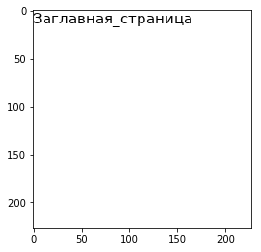

In [11]:
text = "Заглавная_страница"
image = Image.new('L', IMG_SIZE, 255)
draw = ImageDraw.Draw(image)
font = ImageFont.truetype('/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf', 15)
margin = 0
offset = 0
for line in textwrap.wrap(text, width=23):
    draw.text((margin, offset), line, font=font, fill="#000000")
    offset += font.getsize(line)[1]
plt.imshow(image)

In [12]:
def generate_imgs(langs, urls_by_lang, count, fontsizerange):
    for key in langs:
        print 'generating imgs for ' + key
        i = 0
        while i < count:
            wikipedia.set_lang(key)
            res = None
            try:
                res = wikipedia.summary(random.choice(tuple(urls_by_lang[key])).split('/')[-1])
            except:
                continue
            
            text = res
        #     if key == 'en':
        #         for n in re.findall(ur'[a-zA-Z ]+',res):
        #             text = text + n
        #     elif key == 'zh':
        #         for n in re.findall(ur'[\u4e00-\u9fff]+',res):
        #             text = text + n
#             print text


            image = Image.new('L', IMG_SIZE, 255)
            draw = ImageDraw.Draw(image)
        
            if key == 'en':
                font = ImageFont.truetype('/usr/share/fonts/MyFonts/consola.ttf', random.randint(fontsizerange[0], fontsizerange[1]))
                margin = 0
                offset = 0
                for line in textwrap.wrap(text, width=23):
                    draw.text((margin, offset), line, font=font, fill="#000000")
                    offset += font.getsize(line)[1]
            elif key == 'zh':
                font = ImageFont.truetype('/usr/share/fonts/MyFonts/msyh.ttf', random.randint(fontsizerange[0], fontsizerange[1]))
                margin = 0
                offset = 0
                for line in textwrap.wrap(text, width=23):
                    draw.text((margin, offset), line, font=font, fill="#000000")
                    offset += font.getsize(line)[1]
            elif key == 'ru':
                font = ImageFont.truetype('/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf', random.randint(fontsizerange[0], fontsizerange[1]))
                margin = 0
                offset = 0
                for line in textwrap.wrap(text, width=23):
                    draw.text((margin, offset), line, font=font, fill="#000000")
                    offset += font.getsize(line)[1]
            
            image.save(OUTPUT_PATH + key + '-' + str(i) + '-wiki.jpg')
            i += 1

In [15]:
generate_imgs(LANG, urls_by_lang, DATA_SIZE, (10, 50))

generating imgs for ru


/home/will/.local/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file /usr/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html.parser")

  markup_type=markup_type))


generating imgs for en
generating imgs for zh
